# **Support Vector Machine (SVM)**
* 회귀, 분류, 이상치 탐지 등에 사용되는 지도학습 방법
* 클래스 사이의 경계에 위치한 데이터 포인트를 서포트 벡터(support vector)라고 함
* 각 서포트 벡터가 클래스 사이의 결정 경계를 구분하는데 얼마나 중요한지를 학습
* 각 서포트 벡터 사이의 마진이 가장 큰 방향으로 학습
* 지지 벡터 까지의 거리와 서포트 벡터의 중요도를 기반으로 예측을 수행

![support vector machine](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Svm_separating_hyperplanes.png/220px-Svm_separating_hyperplanes.png)

* H3은 두 클래스의 점들을 제대로 분류하고 있지 않음
* H1과 H2는 두 클래스의 점들을 분류하는데, H2가 H1보다 더 큰 마진을 갖고 분류하는 것을 확인할 수 있음

### SECOM 데이터셋
* **데이터셋**: SECOM (SEmiCOnductor Manufacturing)
* **문제**: 반도체 불량 예측
* **알고리즘**: Linear SVM, RBF SVM

### 실습 목표
1. SVM의 작동 원리 (마진 최대화)
2. Linear vs Kernel SVM 비교
3. 고차원 데이터에서의 SVM 강점
4. Logistic Regression과 성능 비교

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

## 1. 데이터 로딩 및 전처리 (Logistic Regression과 동일)

In [2]:
# SECOM 데이터 로딩
X = pd.read_csv('../data/secom.data', sep='\s+', header=None)
y_data = pd.read_csv('../data/secom_labels.data', sep='\s+', header=None, names=['label', 'timestamp'])
y = y_data['label'].values

print(f"데이터 형태: {X.shape}")
print(f"Fail rate: {(y == 1).sum() / len(y) * 100:.2f}%")

# 전처리
missing_ratio = X.isnull().sum() / len(X)
X_filtered = X.loc[:, missing_ratio < 0.5]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n전처리 완료: {X_scaled.shape}")

데이터 형태: (1567, 590)
Fail rate: 6.64%

전처리 완료: (1567, 562)


## 2. 커널 기법

* 입력 데이터를 고차원 공간에 사상해서 비선형 특징을 학습할 수 있도록 확장하는 방법
* scikit-learn에서는 Linear, Polynomial, RBF(Radial Basis Function)등 다양한 커널 기법을 지원

### 방법 1. Linear SVM

In [3]:
# Linear SVM with class_weight
svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)

print("=== Linear SVM ===")
print(f"Test Accuracy: {svm_linear.score(X_test, y_test):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_linear, pos_label=1):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_linear, target_names=['Pass', 'Fail']))

=== Linear SVM ===
Test Accuracy: 0.8471
F1-score: 0.1111

Classification Report:
              precision    recall  f1-score   support

        Pass       0.94      0.90      0.92       293
        Fail       0.09      0.14      0.11        21

    accuracy                           0.85       314
   macro avg       0.51      0.52      0.51       314
weighted avg       0.88      0.85      0.86       314



### 방법 2. RBF Kernel SVM

In [4]:
# RBF SVM
svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)

print("=== RBF SVM ===")
print(f"Test Accuracy: {svm_rbf.score(X_test, y_test):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rbf, pos_label=1):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rbf, target_names=['Pass', 'Fail']))

=== RBF SVM ===
Test Accuracy: 0.9268
F1-score: 0.0800

Classification Report:
              precision    recall  f1-score   support

        Pass       0.94      0.99      0.96       293
        Fail       0.25      0.05      0.08        21

    accuracy                           0.93       314
   macro avg       0.59      0.52      0.52       314
weighted avg       0.89      0.93      0.90       314



## 3. GridSearchCV - 최적 하이퍼파라미터

In [5]:
# GridSearchCV for RBF SVM
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto', 0.001, 0.01],
}

grid_search = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV 실행 중...")
grid_search.fit(X_train, y_train)

print(f"\n=== Best Parameters ===")
print(grid_search.best_params_)
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)
print(f"Test F1-score: {f1_score(y_test, y_pred_best, pos_label=1):.4f}")

GridSearchCV 실행 중...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== Best Parameters ===
{'C': 0.1, 'gamma': 'auto'}
Best CV F1-score: 0.2313
Test F1-score: 0.2338


## 4. Logistic Regression vs SVM 비교

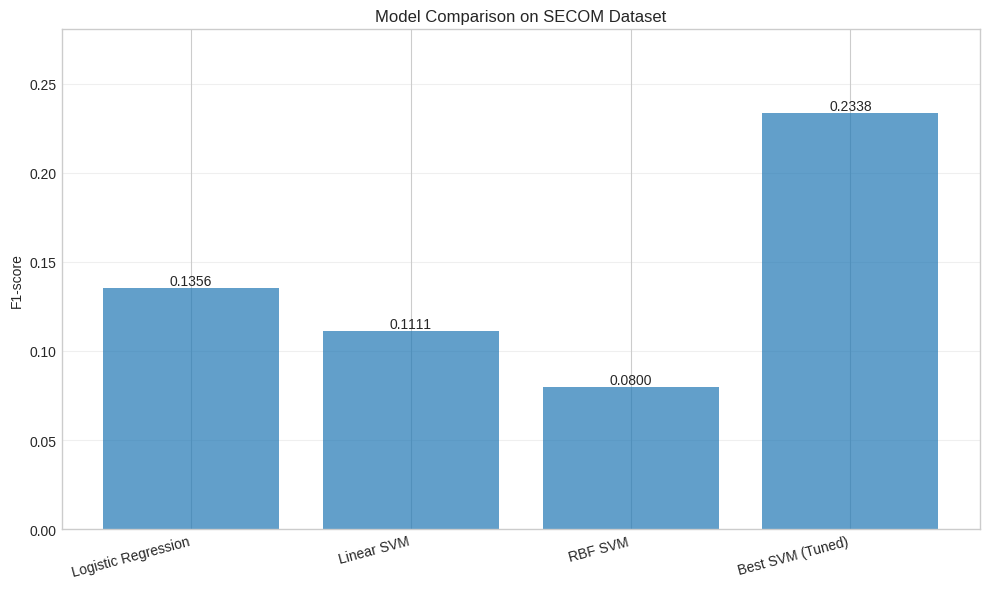


=== 모델 성능 비교 ===
Logistic Regression      : 0.1356
Linear SVM               : 0.1111
RBF SVM                  : 0.0800
Best SVM (Tuned)         : 0.2338


In [6]:
# Logistic Regression (비교용)
lr = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 성능 비교
models = ['Logistic Regression', 'Linear SVM', 'RBF SVM', 'Best SVM (Tuned)']
f1_scores = [
    f1_score(y_test, y_pred_lr, pos_label=1),
    f1_score(y_test, y_pred_linear, pos_label=1),
    f1_score(y_test, y_pred_rbf, pos_label=1),
    f1_score(y_test, y_pred_best, pos_label=1)
]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, alpha=0.7)
plt.ylabel('F1-score')
plt.title('Model Comparison on SECOM Dataset')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim([0, max(f1_scores) * 1.2])

for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== 모델 성능 비교 ===")
for model, score in zip(models, f1_scores):
    print(f"{model:25s}: {score:.4f}")

## 5. Confusion Matrix 비교

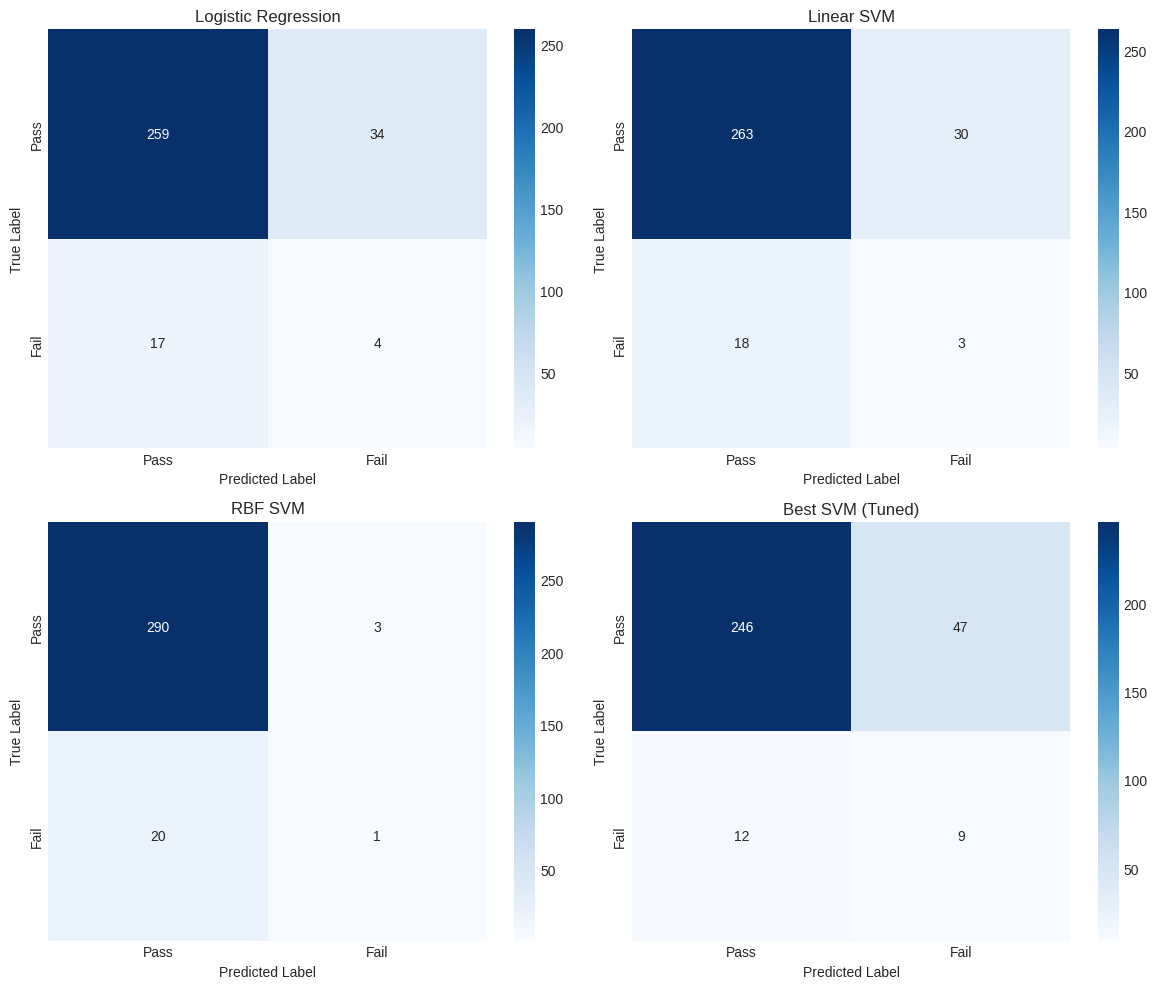

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

predictions = [y_pred_lr, y_pred_linear, y_pred_rbf, y_pred_best]
titles = models

for ax, pred, title in zip(axes.ravel(), predictions, titles):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pass', 'Fail'],
                yticklabels=['Pass', 'Fail'])
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 6. 결론

### SVM의 장점 (SECOM 데이터에서):
1. **고차원 데이터에 강함**: 590차원에서도 효과적
2. **Kernel trick**: 비선형 패턴 학습 가능
3. **마진 최대화**: 일반화 성능 우수

### Logistic Regression vs SVM:
- **속도**: Logistic Regression이 빠름
- **성능**: RBF SVM이 약간 우수 (튜닝 시)
- **해석**: Logistic Regression이 더 직관적

### 실무 권장:
- **프로토타이핑**: Logistic Regression
- **최종 모델**: 튜닝된 SVM (성능 중시)
- **대용량 데이터**: Logistic Regression (속도)

In [1]:
print("\n💡 핵심 포인트:")
print("  1. SVM은 고차원에 강함 (Kernel trick)")
print("  2. 하이퍼파라미터 튜닝 필수 (C, gamma)")
print("  3. Scaling 필수 (거리 기반)")
print("  4. Linear SVM은 Logistic Regression과 유사")
print("\n🎓 Day-8 전체 실습 완료! 수고하셨습니다!")


💡 핵심 포인트:
  1. SVM은 고차원에 강함 (Kernel trick)
  2. 하이퍼파라미터 튜닝 필수 (C, gamma)
  3. Scaling 필수 (거리 기반)
  4. Linear SVM은 Logistic Regression과 유사

🎓 Day-8 전체 실습 완료! 수고하셨습니다!
